In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import Aircraft

# Optimise speed ratio

Distance flown: 16828.036808806457 | Time of flight: 78180.0 | Number of iterations: 7818


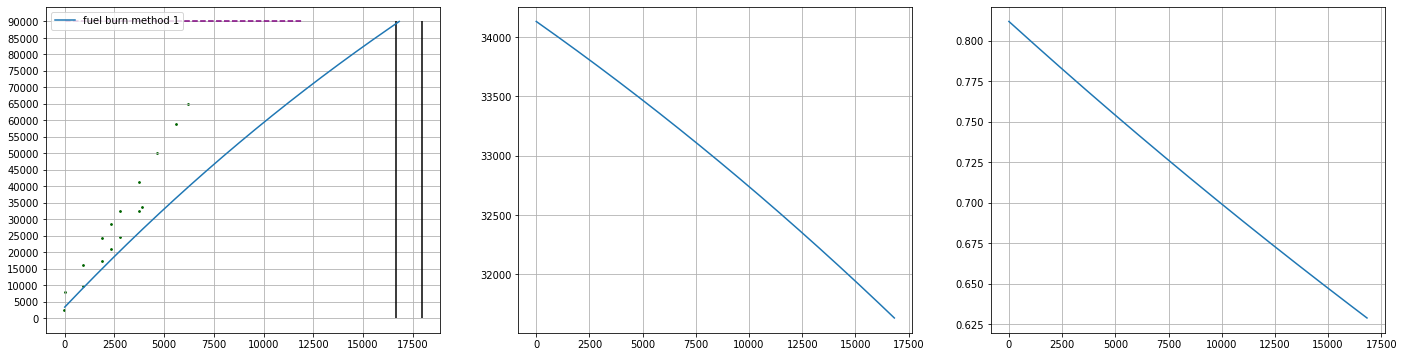

In [2]:
notesData = '-13.779527559055055, 2508.960573476652; 930.1181102362204, 9677.419354838668; 1860.236220472441, 17275.985663082407; 2321.850393700787, 21003.584229390646; 2790.354330708661, 24587.81362007164; 3727.36220472441, 32329.749103942624; 3861.712598425197, 33548.38709677418; 0, 7956.98924731178; 926.6732283464567, 15985.663082437255; 1853.3464566929133, 24157.706093189918; 2328.740157480315, 28458.78136200717; 2790.354330708661, 32616.4874551971; 3727.36220472441, 41290.32258064514; 4664.370078740157, 50179.21146953403; 5594.488188976376, 58996.415770609296; 6204.232283464566, 65089.605734767'
notesSFB, notesFB = zip(*[(float(datapoint.split(', ')[0]), float(datapoint.split(', ')[1])) for datapoint in notesData.split('; ')])

timestep = 10 # s

# Analysis variables
vRat = 1.016 # Ratio of EAS to optimal EAS
initCruiseAlt = 9.5
W_P = 24000
W_F = 220_000 - W_P - 106_000

# vCruise = 256
# MCruise = 0.85
# LDCruise = 21

aircraftSpecs = {'W_E':106_000, 'W_MP':40_000, 'W_MTO':220_000, 'W_P':W_P, 'W_F':W_F, # Weight specs
                    'maxPass':240, 'MPRange':12_000, 'W_F_MP':74_000, 'SWing':315, # Other aircraft specs
                    'rEgnine':45, 'thetEngine':6, 'effComp':0.9, 'effTurb':0.9, 'FPREngine':1.45, 'effFan':0.92, 'effTransfer':0.9, 'LCVFuel':42.7e6, # Engine
                    'timestep':timestep, 'k':0.015, 'c1':0.3, 'c2':1.0, 'K1':0.0125, 'K2':0.0446, 'vRat':vRat} # Model parameters

aircraft = Aircraft(aircraftSpecs)

altitudes = initCruiseAlt * np.ones(10)

distances = []
times = []
fuelBurns = []
machs = []
Hs = []
LDRats = []
weights = []
effOveralls = []
effCycles = []
effProps = []
W_CO2s = []
W_NOXs = []

while aircraft.W_F > 0:
    aircraft.updateAllFlightValues(initCruiseAlt, ft=False, MOvrd=-1)

    distances.append(aircraft.s/1000)
    times.append(aircraft.time)
    fuelBurns.append(aircraft.W_FB)
    machs.append(aircraft.M)
    Hs.append(aircraft.H)
    LDRats.append(1/aircraft.beta)
    weights.append(aircraft.W)
    effOveralls.append(aircraft.effOverall)
    effCycles.append(aircraft.effCycle)
    effProps.append(aircraft.effProp)
    W_CO2s.append(aircraft.W_CO2)
    W_NOXs.append(aircraft.W_NOX)

print(f'Distance flown: {distances[-1]} | Time of flight: {times[-1]} | Number of iterations: {len(distances)}')

HsPredictions = [H*np.log((106000+W_P+W_F)/(106000+W_P))/1000 for H in Hs[1:]]


# General information plots
plt.figure(figsize=[24,6])

plt.subplot(1,3,1)
plt.plot(distances, fuelBurns, label='fuel burn method 1')
plt.hlines(W_F, 0, 12000, linestyles='--', color='purple')
plt.vlines([max(HsPredictions), min(HsPredictions)], 0, W_F)
plt.scatter(notesSFB, notesFB, s=3, color='darkgreen')
plt.yticks(np.arange(0,max(fuelBurns),5000))
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.plot(distances, np.array(Hs)/1000)
plt.grid()

plt.subplot(1,3,3)
plt.plot(distances, machs)
plt.grid()

plt.show()

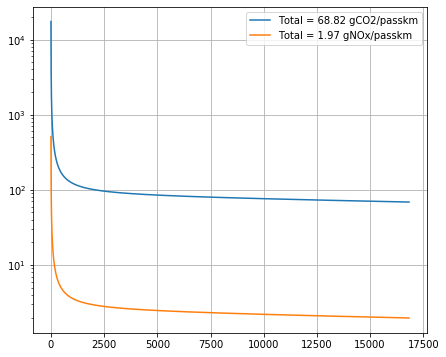

In [9]:
gNOxPPKM = np.array(W_NOXs[1:]) / (240*np.array(distances[1:]))
gCO2PPKM = np.array(W_CO2s[1:]) / (240*np.array(distances[1:]))

# Pollution related plots
plt.figure(figsize=[24,6])

plt.subplot(1,3,1)
plt.yscale('log')
plt.plot(distances[1:], gCO2PPKM, label=f'Total = {round(gCO2PPKM[-1], 2)} gCO2/passkm')
plt.plot(distances[1:], gNOxPPKM, label=f'Total = {round(gNOxPPKM[-1], 2)} gNOx/passkm')
plt.grid()
plt.legend()
plt.show()

In [5]:
s12000 = np.where(np.array(distances)>12000)[0][0]
print(distances[s12000])
print(W_F - fuelBurn[s12000])
print(machs[0], machs[s12000])

12001.284491731032
21134.529713752054
0.8118132053729543 0.6779669222437281


In [12]:
print(effOveralls)

[0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.37470384119099254, 0.3747038411

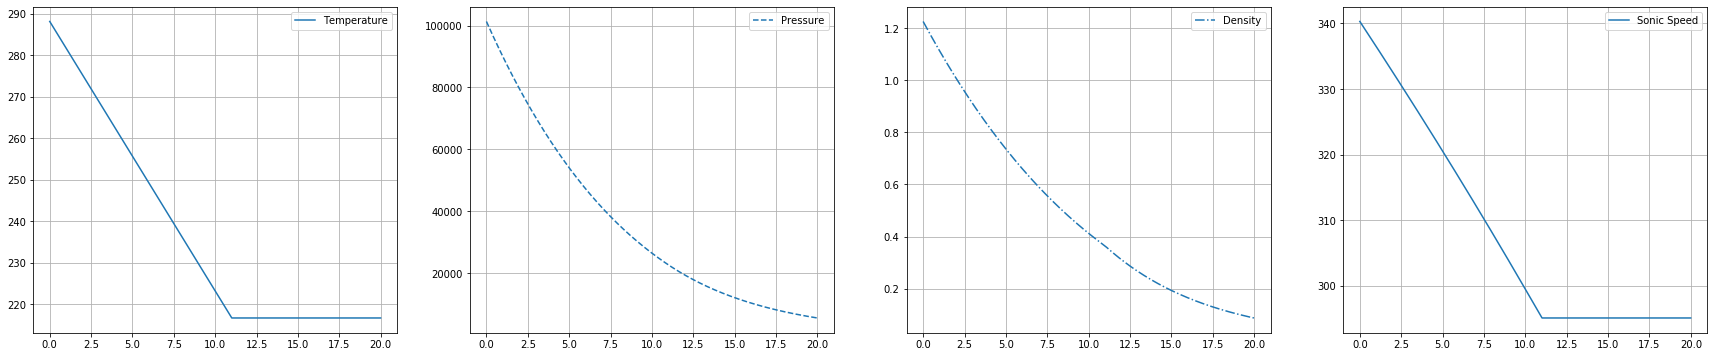

216.65 5482.699821515687 0.0881844697552786


In [3]:
T_sl = 288.15
p_sl = 101325
rho_sl = 1.225
a_sl = 340.3

TRat = []
pRat = []
rhoRat = []
aRat = []

hRange = np.arange(0,20,0.01)

for h in hRange:
    if h <= 11:
        T = T_sl - 6.5*h
        TRat.append(T)

        pRat.append((T/T_sl)**5.256 * p_sl)
        rhoRat.append((T/T_sl)**4.256 * rho_sl)
        aRat.append((T/T_sl)**0.5 * a_sl)
    elif h <= 20:
        T = 216.65
        TRat.append(T)

        tropRat = np.exp(-0.1577*(h-11))
        pRat.append(tropRat * 22631)
        rhoRat.append(tropRat * 0.364)
        aRat.append((T/T_sl)**0.5*a_sl)

plt.figure(figsize=[30,6])
plt.subplot(1,4,1)
plt.plot(hRange, TRat, label='Temperature')
plt.legend()
plt.grid()
plt.subplot(1,4,2)
plt.plot(hRange, pRat, label='Pressure', linestyle='--')
plt.legend()
plt.grid()
plt.subplot(1,4,3)
plt.plot(hRange, rhoRat, label='Density', linestyle='-.')
plt.legend()
plt.grid()
plt.subplot(1,4,4)
plt.plot(hRange, aRat, label='Sonic Speed')
plt.legend()
plt.grid()

plt.show()

print(TRat[-1], pRat[-1], rhoRat[-1])